# Using pre-trained model

In [31]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = "Dataset/images/"
label_path = 'Dataset/labels.csv'

# Load the labels from the CSV file
labels_df = pd.read_csv(label_path)
labels = labels_df['label'].tolist()

# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow from the directory and split the data into training and validation sets
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=data_path,
    x_col="image",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=data_path,
    x_col="image",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

# Load the VGG16 model
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

# Freeze the base model

for layer in base_model.layers[:-15]:
  layer.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(14, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

# Train the model
model.fit(train_generator, validation_data=valid_generator, epochs=10)

Found 91 validated image filenames belonging to 14 classes.
Found 22 validated image filenames belonging to 14 classes.


Epoch 1/10
3/3 [==============================] - 169s 51s/step - loss: 4.3434 - categorical_accuracy: 0.0549 - val_loss: 2.8401 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 156s 51s/step - loss: 2.5770 - categorical_accuracy: 0.0879 - val_loss: 4.3646 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 147s 48s/step - loss: 2.5536 - categorical_accuracy: 0.0879 - val_loss: 4.4379 - val_categorical_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 152s 51s/step - loss: 2.8866 - categorical_accuracy: 0.0769 - val_loss: 4.8365 - val_categorical_accuracy: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 151s 53s/step - loss: 2.4968 - categorical_accuracy: 0.1209 - val_loss: 5.2851 - val_categorical_accuracy: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 148s 48s/step - loss: 2.5490 - categorical_accuracy: 0.1099 - val_loss: 4.4762 - val_categorical_accuracy: 0.0

# Import necessary libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from config import Config
from utils import get_regularized_model, get_image_data_generator
from data_preprocessing import load_and_preprocess_images, encode_labels, load_data

# Load data & Create data generators

In [33]:
x_train, x_val, y_train, y_val, label_to_name = load_data("Dataset/images/", "Dataset/labels.csv")

# Encode data in the right format
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

x_train_processed = load_and_preprocess_images(x_train, target_size=(224, 224))
x_val_processed = load_and_preprocess_images(x_val, target_size=(224, 224))

y_train_encoded = encode_labels(y_train)
y_val_encoded = encode_labels(y_val)

train_data_generator = get_image_data_generator(
    Config.rotation_range,
    Config.width_shift_range,
    Config.height_shift_range,
    Config.shear_range,
    Config.zoom_range,
    Config.horizontal_flip,
    Config.vertical_flip
)

# No data augmentation for validation
val_data_generator = get_image_data_generator(0, 0, 0, 0, 0, False, False)

# Define & Compile the model

In [3]:
model = get_regularized_model(Config.input_shape, Config.num_classes, Config.dropout_rate, Config.l2_regularization)

model.compile(optimizer=Adam(learning_rate=Config.learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks

In [4]:
checkpoint = ModelCheckpoint("Results/Model_Weights/best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

# Train the model

In [6]:
history = model.fit(
    train_data_generator.flow(x_train_processed, y_train_encoded, batch_size=Config.batch_size),
    steps_per_epoch=len(x_train_processed) // Config.batch_size,
    epochs=Config.epochs,
    validation_data=val_data_generator.flow(x_val_processed, y_val_encoded, batch_size=Config.batch_size),
    validation_steps=len(x_val_processed) // Config.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


7/7 [==============================] - ETA: 0s - loss: 3.4980 - accuracy: 0.0897

f:\Desktop\Programming\DeepLearning\MiniProject\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 53s 7s/step - loss: 3.4980 - accuracy: 0.0897 - val_loss: 3.0326 - val_accuracy: 0.0833
Epoch 2/10
7/7 [==============================] - 27s 3s/step - loss: 2.9203 - accuracy: 0.0897 - val_loss: 2.8589 - val_accuracy: 0.0833
Epoch 3/10
7/7 [==============================] - 27s 3s/step - loss: 2.8387 - accuracy: 0.1071 - val_loss: 2.8093 - val_accuracy: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 30s 3s/step - loss: 2.7777 - accuracy: 0.0897 - val_loss: 2.7476 - val_accuracy: 0.1667
Epoch 5/10
7/7 [==============================] - 26s 3s/step - loss: 2.7348 - accuracy: 0.0897 - val_loss: 2.7381 - val_accuracy: 0.0000e+00
Epoch 6/10
7/7 [==============================] - 31s 3s/step - loss: 2.7109 - accuracy: 0.0769 - val_loss: 2.6607 - val_accuracy: 0.1667
Epoch 7/10
7/7 [==============================] - 28s 3s/step - loss: 2.6780 - accuracy: 0.1310 - val_loss: 2.6904 - val_accuracy: 0.0833
Epoch 8/10
7/7 [=====================

# Save the final model & training history

In [7]:
model.save("Results/Model_Weights/final_model.h5")
np.save("Results/Plots/training_history.npy", history.history)

# Evaluate the model on the test set

In [8]:
test_data_generator = get_image_data_generator(0, 0, 0, 0, 0, False, False)

# Load & evaluae the best model

In [9]:
best_model = load_model("Results/Model_Weights/best_model.h5")

# Evaluate the model
eval_result = best_model.evaluate(test_data_generator.flow(x_val_processed, y_val_encoded, batch_size=Config.batch_size),
                                  steps=len(x_val) // Config.batch_size)
print("\nEvaluation Loss: {:.4f}".format(eval_result[0]))
print("Evaluation Accuracy: {:.2%}".format(eval_result[1]))

1/1 [==============================] - 10s 10s/step - loss: 2.7514 - accuracy: 0.1667

Evaluation Loss: 2.7514
Evaluation Accuracy: 16.67%


# Predict classes for test set

In [11]:
from utils import predict_single_image


image_path = "Dataset/images/2.jpg"
target_size = (224, 224)  # Adjust the target size based on your model's input size

predicted_class = predict_single_image(best_model, image_path, target_size)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 19s 19s/step
Predicted Class: [9]


In [12]:
y_pred = best_model.predict(test_data_generator.flow(x_val_processed, batch_size=Config.batch_size)).argmax(axis=1)

2/2 [==============================] - 17s 349ms/step


# Convert numerical labels back to student names

In [13]:
import pandas as pd

In [25]:
labels_df = pd.read_csv("Dataset/labels.csv")
y_val = labels_df['label'].tolist()
y_val = sorted(list(set(y_val)))

# Encode y_val to get y_val_encoded
y_val_encoded = encode_labels(y_val)

# Assuming y_pred_encoded contains encoded labels directly
y_pred_encoded = np.array(y_pred)

# Create a mapping from encoded labels to class names
label_to_name_encoded = {label: name for name, label in zip(y_val, y_val_encoded)}

# Map encoded labels back to class names for y_val_encoded and y_pred_encoded
y_val_names = [label_to_name_encoded[label] for label in y_val_encoded]
y_pred_names = [label_to_name_encoded[label] for label in y_pred_encoded]

print("Actual labels (y_val_names):", y_val_names)
print("Predicted labels (y_pred_names):", y_pred_names)

Actual labels (y_val_names): ['ABDERAHMANI_Issam', 'BAHRI_Mohamed_Mouloud', 'BENAGGOUNE_Skander', 'BENGUESSOUM_Ahmed_Rached', 'BERGHOUTH_Imene', 'CHAHI_Kamel_Eddine', 'CHEMMAMI_Abdrezak', 'HORRI_Mourad', 'HOUACHE_Mohamed', 'HOUASNIA_Aymen_Ahmed', 'KHALFI_Abdelwadoud', 'OMERANI_Ala_Eddine', 'TERCHI_Chaima', 'ZERAIB_Ranya']
Predicted labels (y_pred_names): ['HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed', 'HOUASNIA_Aymen_Ahmed']


# Plot training history

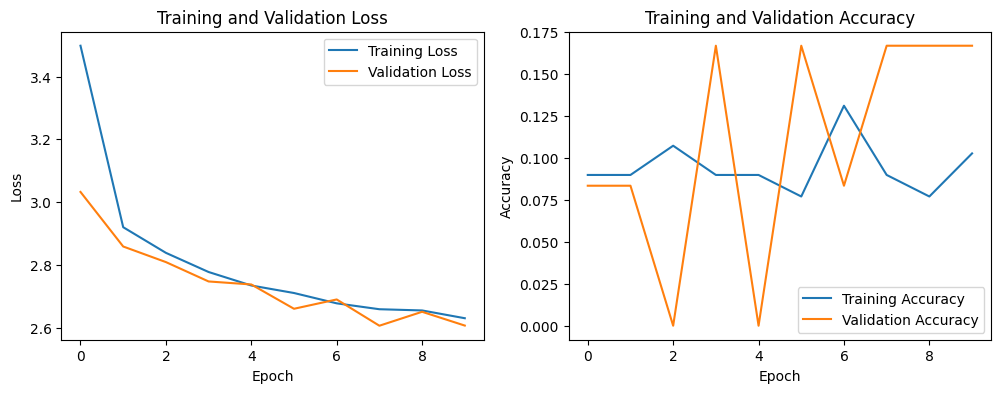

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the plots

In [27]:
plt.savefig("Results/Plots/training_and_validation_plots.png")

<Figure size 640x480 with 0 Axes>